# Probabilistic Programming - Final Project
## Recommendation System using Hierarchical Poisson Factorization 
### Stan Eduard-George (407 AI)

We start by importing the libraries that we'll work with.

In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

The data used for this project is Fashion Products dataset (Can be accessed at https://www.kaggle.com/datasets/bhanupratapbiswas/fashion-products).

Then, we read the dataset and store it in a pd.DataFrame. We perform a quick check of the most important characteristics of our data (number of rows and columns, data types, missing values, memory usage).

In [2]:
data = pd.read_csv("fashion_products.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   User ID       1000 non-null   int64  
 1   Product ID    1000 non-null   int64  
 2   Product Name  1000 non-null   object 
 3   Brand         1000 non-null   object 
 4   Category      1000 non-null   object 
 5   Price         1000 non-null   int64  
 6   Rating        1000 non-null   float64
 7   Color         1000 non-null   object 
 8   Size          1000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB


We display the first 5 rows, so that we can see how the values really look. We notice three categorical columns - **Brand**, **Product Name**, **Category**. These columns can be used to detect the users that rated more specific or more general articles. 

In [3]:
data.head(5)

,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


We set to 9 the number of unique users and articles that we'll use for the sanity check of our model. We combine the three columns observed earlier. This means that we want to extract the most relevant information possible about the products that we're going to recommend.

Next, we extract first 9 of the most frequently rated articles, and we display their names and number of ratings. Firstly, we notice that the number of ratings by different users (22, 21 etc.) is sufficiently big for our 1000 raws dataset, and especially for the shrunk 9users x 9articles sanity check dataset. Secondly, the number of unique articles is 75 (once again, an amazing number for our dimensionality).

In [4]:
dimension = 9
data["Article"] = data["Brand"] + ' ' + data["Product Name"] + ' ' + data["Category"]
unique_articles, counts_articles = np.unique(data["Article"], return_counts=True)

best_unique_articles = unique_articles[np.argsort(counts_articles)[-dimension:][::-1]]
best_counts_articles = counts_articles[np.argsort(counts_articles)[-dimension:][::-1]]

print(f"Number of unique articles: {len(unique_articles)}\n\nTop {dimension} most frequently rated articles:\n\
      {best_unique_articles} \n\nCounts of the mentioned articles:\n\
      {best_counts_articles}")

Number of unique articles: 75

Top 9 most frequently rated articles:
      ["Gucci Jeans Women's Fashion" "H&M Jeans Kids' Fashion"
 "Zara T-shirt Kids' Fashion" "Nike Jeans Kids' Fashion"
 "Gucci Shoes Kids' Fashion" "Zara Jeans Men's Fashion"
 "Nike T-shirt Men's Fashion" "H&M Sweater Kids' Fashion"
 "Zara Shoes Men's Fashion"] 

Counts of the mentioned articles:
      [22 21 20 20 19 19 18 18 18]


We do the same thing as earlier with the Users' IDs. The total number of unique users is 100, which means that the average ratings/user is 10.

In [5]:
unique_user, counts_user = np.unique(data["User ID"], return_counts=True)
best_unique_user = unique_user[np.argsort(counts_user)[-dimension:][::-1]]
best_counts_user = counts_user[np.argsort(counts_user)[-dimension:][::-1]]
print(f"Number of unique users: {len(unique_user)}\n\nTop {dimension} most active users by ID:\n\
      {best_unique_user} \n\nThe number of their ratings:\n\
      {best_counts_user}")

Number of unique users: 100

Top 9 most active users by ID:
      [37 65 34 46 80  9 89 25 77] 

The number of their ratings:
      [18 17 16 15 15 15 15 14 14]


At this step, we create the sanity check dataset.
We select only the instances that contain the most rated articles and the most active users. This way, the new dataset has 29 rows.

In [6]:
selected_rows = data[(data['Article'].isin(best_unique_articles)) & (data['User ID'].isin(best_unique_user))]
best_samples_data = selected_rows[['User ID', 'Article', 'Rating']]
f"Number of instances in best_samples_data: {len(best_samples_data)}"

'Number of instances in best_samples_data: 29'

We factorize the values of columns **Article** and **User ID** to make them easier to interpret.

In [7]:
best_samples_data.loc[:,'Article'], _ = pd.factorize(best_samples_data['Article'])
best_samples_data.loc[:,'User ID'], _ = pd.factorize(best_samples_data['User ID'])
best_samples_data.head(5)

,User ID,Article,Rating
12,0,0,1.601194
24,1,1,1.020493
76,2,1,2.228263
77,0,2,1.297257
108,3,0,2.727660


Below, the interaction matrix of **Article** vs **User ID** is displayed. The rounded ratings are shown over the intersections of the two values.

<Axes: >

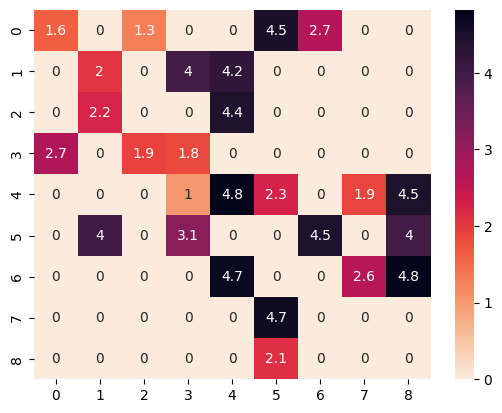

In [8]:
inter_matrix = np.array(pd.pivot_table(best_samples_data, values='Rating', index='User ID', columns='Article', fill_value=0))
sns.heatmap(inter_matrix, cmap=sns.cm.rocket_r, annot=True)

Prepare variables for the grid search:
- **\<name\>_list** - stores the parameters for which MAE is measured.
- **\<name\>_mae_list** - stores the values of MAE calculated for the correspondent parameter in **\<name\>_list**.

In [25]:
draws_list = [500, 750, 1000, 1250, 1500]
draws_mae_list = []
tune_list = [250, 500, 750, 1000]
tune_mae_list = []

Grid search on **draws** and **tune** parameters of **trace**:

In [26]:

for tune in tune_list:
    with pm.Model() as model:
        a, a_pr, b, b_pr = 0.3, 0.3, 0.3, 0.3
        sample_activity = pm.Gamma('sample_activity', alpha=a_pr, beta=a_pr/b_pr, initval=np.mean(inter_matrix, axis=1), shape=dimension)

        c, c_pr, d, d_pr = 0.3, 0.3, 0.3, 0.3
        prior_alpha_popularity = pm.Gamma("prior_alpha_popularity", alpha=c_pr, beta=d_pr, initval=12)
        sample_popularity = pm.Gamma('sample_popularity', alpha=c_pr, beta=c_pr/d_pr, initval=np.mean(inter_matrix, axis=0), shape=dimension)

        theta = pm.Gamma('theta', alpha=a, beta=sample_activity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))
        beta = pm.Gamma('beta', alpha=c, beta=sample_popularity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))

        ratings = pm.Poisson('ratings', mu=pm.math.dot(theta.T, beta), observed=inter_matrix)

        trace = pm.sample(1200, tune=tune, cores=2, return_inferencedata=False, target_accept=0.9)

        posterior_predictive = pm.sample_posterior_predictive(trace)
        ratings_samples = posterior_predictive['ratings']

    predicted_ratings = np.mean(ratings_samples, axis=0)
    tune_mae_list.append(np.mean(np.abs(predicted_ratings - inter_matrix)))



for draws in draws_list:
    with pm.Model() as model:
        a, a_pr, b, b_pr = 0.3, 0.3, 0.3, 0.3
        sample_activity = pm.Gamma('sample_activity', alpha=a_pr, beta=a_pr/b_pr, initval=np.mean(inter_matrix, axis=1), shape=dimension)

        c, c_pr, d, d_pr = 0.3, 0.3, 0.3, 0.3
        prior_alpha_popularity = pm.Gamma("prior_alpha_popularity", alpha=c_pr, beta=d_pr, initval=12)
        sample_popularity = pm.Gamma('sample_popularity', alpha=c_pr, beta=c_pr/d_pr, initval=np.mean(inter_matrix, axis=0), shape=dimension)

        theta = pm.Gamma('theta', alpha=a, beta=sample_activity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))
        beta = pm.Gamma('beta', alpha=c, beta=sample_popularity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))

        ratings = pm.Poisson('ratings', mu=pm.math.dot(theta.T, beta), observed=inter_matrix)

        trace = pm.sample(draws, tune=500, cores=2, return_inferencedata=False, target_accept=0.9)

        posterior_predictive = pm.sample_posterior_predictive(trace)
        ratings_samples = posterior_predictive['ratings']

    predicted_ratings = np.mean(ratings_samples, axis=0)
    draws_mae_list.append(np.mean(np.abs(predicted_ratings - inter_matrix)))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_200 draw iterations (500 + 2_400 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 500 tune and 1_200 draw iterations (1_000 + 2_400 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 750 tune and 1_200 draw iterations (1_500 + 2_400 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 1_000 tune and 1_200 draw iterations (2_000 + 2_400 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 500 tune and 750 draw iterations (1_000 + 1_500 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 500 tune and 1_250 draw iterations (1_000 + 2_500 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


Plot MAE as a function of the correspondent measured parameter.

In the following plots, the darker colors mean lower values!!!

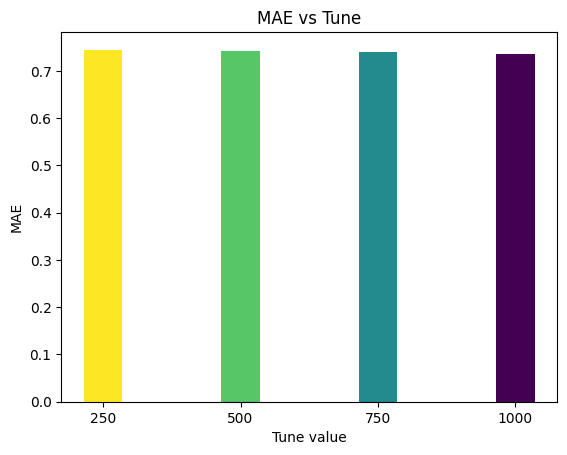

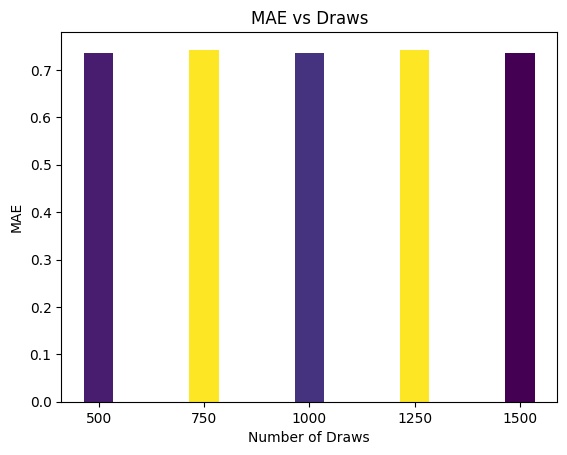

In [35]:
colormap = plt.cm.viridis
normalize = plt.Normalize(min(tune_mae_list), max(tune_mae_list))
colormap_mapped = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
colors = colormap_mapped.to_rgba(tune_mae_list)

plt.bar(tune_list, tune_mae_list, width=70, color=colors)

plt.xlabel('Tune value')
plt.ylabel('MAE')
plt.title('MAE vs Tune')
plt.xticks(tune_list)
plt.show()

normalize = plt.Normalize(min(draws_mae_list), max(draws_mae_list))
colormap_mapped = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
colors = colormap_mapped.to_rgba(draws_mae_list)

plt.bar(draws_list, draws_mae_list, width=70, color=colors)

plt.xlabel('Number of Draws')
plt.ylabel('MAE')
plt.title('MAE vs Draws')
plt.xticks(draws_list)
plt.show()

We do not notice any improvement in the value of MAE in any of the two parameters studied. We decide on a decent value of tune=500/draws=1000 for our model, just in case the model won't converge for higher scales. Also, here are the parameters for the next grid search:
- **gamma_vals** - stores the parameters for which MAE is measured. These are the values for a, b, c, d and their primes (basically, alpha and beta parameters of the Gamma distributions).
- **gamma_vals_list** - stores the values of MAE calculated for the correspondent parameter in **gamma_vals**.

In [37]:
final_tune = 500
final_draws = 1000
gamma_vals = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.5]
gamma_vals_list = []

Grid search on the parameters of Gamma distributions:

In [38]:

for val in gamma_vals:
    with pm.Model() as model:
        a, a_pr, b, b_pr = val, val, val, val
        sample_activity = pm.Gamma('sample_activity', alpha=a_pr, beta=a_pr/b_pr, initval=np.mean(inter_matrix, axis=1), shape=dimension)

        c, c_pr, d, d_pr = val, val, val, val
        prior_alpha_popularity = pm.Gamma("prior_alpha_popularity", alpha=c_pr, beta=d_pr, initval=12)
        sample_popularity = pm.Gamma('sample_popularity', alpha=c_pr, beta=c_pr/d_pr, initval=np.mean(inter_matrix, axis=0), shape=dimension)

        theta = pm.Gamma('theta', alpha=a, beta=sample_activity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))
        beta = pm.Gamma('beta', alpha=c, beta=sample_popularity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))

        ratings = pm.Poisson('ratings', mu=pm.math.dot(theta.T, beta), observed=inter_matrix)

        trace = pm.sample(final_draws, tune=final_tune, cores=2, return_inferencedata=False, target_accept=0.9)

        posterior_predictive = pm.sample_posterior_predictive(trace)
        ratings_samples = posterior_predictive['ratings']

    predicted_ratings = np.mean(ratings_samples, axis=0)
    gamma_vals_list.append(np.mean(np.abs(predicted_ratings - inter_matrix)))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 35 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 10 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 6 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 3 seconds.


Here, we plot the correlation between MAE and the different values of the Gamma distributions. We observe that lower values of alpha and beta mean a better MAE. We continue to investigate before choosing the final value.

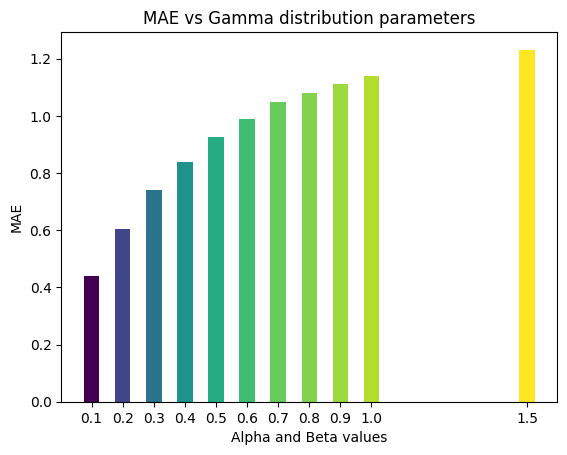

In [45]:
colormap = plt.cm.viridis
normalize = plt.Normalize(min(gamma_vals_list), max(gamma_vals_list))
colormap_mapped = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
colors = colormap_mapped.to_rgba(gamma_vals_list)

plt.bar(gamma_vals, gamma_vals_list, width=.05, color=colors)

plt.xlabel('Alpha and Beta values')
plt.ylabel('MAE')
plt.title('MAE vs Gamma distribution parameters')
plt.xticks(gamma_vals)
plt.show()

We measure MAE for lower values of the Gamma distribution parameters

In [49]:
gamma_vals_small = [.01, .03, .05, .07, .09, .1]
gamma_vals_small_list = []

In [50]:
for val in gamma_vals_small:
    with pm.Model() as model:
        a, a_pr, b, b_pr = val, val, val, val
        sample_activity = pm.Gamma('sample_activity', alpha=a_pr, beta=a_pr/b_pr, initval=np.mean(inter_matrix, axis=1), shape=dimension)

        c, c_pr, d, d_pr = val, val, val, val
        prior_alpha_popularity = pm.Gamma("prior_alpha_popularity", alpha=c_pr, beta=d_pr, initval=12)
        sample_popularity = pm.Gamma('sample_popularity', alpha=c_pr, beta=c_pr/d_pr, initval=np.mean(inter_matrix, axis=0), shape=dimension)

        theta = pm.Gamma('theta', alpha=a, beta=sample_activity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))
        beta = pm.Gamma('beta', alpha=c, beta=sample_popularity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))

        ratings = pm.Poisson('ratings', mu=pm.math.dot(theta.T, beta), observed=inter_matrix)

        trace = pm.sample(final_draws, tune=final_tune, cores=2, return_inferencedata=False, target_accept=0.9)

        posterior_predictive = pm.sample_posterior_predictive(trace)
        ratings_samples = posterior_predictive['ratings']

    predicted_ratings = np.mean(ratings_samples, axis=0)
    gamma_vals_small_list.append(np.mean(np.abs(predicted_ratings - inter_matrix)))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 38 seconds.
There were 963 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8288332141799676, but should be close to 0.9. Try to increase the number of tuning steps.
There were 979 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6983496828222925, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 94 seconds.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8366643410984546, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 452 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8363615150749042, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 79 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 42 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 38 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 250 tune and 1_000 draw iterations (500 + 2_000 draws total) took 37 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


This final plot tells us that, indeed, MAE is directly proportional to the values of the Gamma distribution parameters. Therefore, the problem is that the lowest values in this graph also make the model diverge... For example, the number of divergences for the Gamma parameter values of 0.01 is 1,942 :\(

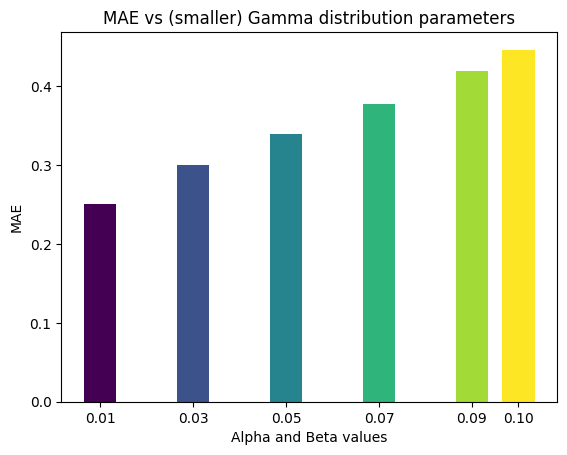

In [64]:
colormap = plt.cm.viridis
normalize = plt.Normalize(min(gamma_vals_small_list), max(gamma_vals_small_list))
colormap_mapped = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
colors = colormap_mapped.to_rgba(gamma_vals_small_list)

plt.bar(gamma_vals_small, gamma_vals_small_list, width=.007, color=colors)

plt.xlabel('Alpha and Beta values')
plt.ylabel('MAE')
plt.title('MAE vs (smaller) Gamma distribution parameters')
plt.xticks(gamma_vals_small)
plt.show()

Due to the number of divergences, we choose **0.1** as being the best value for **the parameters of the Gamma distribution**. 

The parameters we'll stick with are:
- gamma_parameters = 0.1
- draws = 1000
- tune = 500

Final model:

In [9]:
# Create the PyMC3 model
with pm.Model() as model:
    a, a_pr, b, b_pr = 0.1, 0.1, 0.1, 0.1
    sample_activity = pm.Gamma('sample_activity', alpha=a_pr, beta=a_pr/b_pr, initval=np.mean(inter_matrix, axis=1), shape=dimension)

    c, c_pr, d, d_pr = 0.1, 0.1, 0.1, 0.1
    prior_alpha_popularity = pm.Gamma("prior_alpha_popularity", alpha=c_pr, beta=d_pr, initval=12)
    sample_popularity = pm.Gamma('sample_popularity', alpha=c_pr, beta=c_pr/d_pr, initval=np.mean(inter_matrix, axis=0), shape=dimension)

    theta = pm.Gamma('theta', alpha=a, beta=sample_activity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))
    beta = pm.Gamma('beta', alpha=c, beta=sample_popularity, initval=np.random.rand(dimension, dimension), shape=(dimension, dimension))

    ratings = pm.Poisson('ratings', mu=pm.math.dot(theta.T, beta), observed=inter_matrix)

    trace = pm.sample(1000, tune=500, cores=2, return_inferencedata=False, target_accept=0.9)

    posterior_predictive = pm.sample_posterior_predictive(trace)
    ratings_samples = posterior_predictive['ratings']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sample_popularity, prior_alpha_popularity, sample_activity]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 41 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Once again, print the Mean Absolute Error for this final model:

In [10]:
predicted_ratings = np.mean(ratings_samples, axis=0)
mae = np.mean(np.abs(predicted_ratings - inter_matrix))
print(mae)

0.44161423249329795


Here are the original and the predicted interaction matrices. We round the ratings to the closest integer because the values that should be 0 are actually dragged toward the mean. In other words, 0 values are more like 0.2/0.3/0.4, depending on their place on the matrix. 

However, the results look great, even though the extreme values are a little bit closer to the mean than they should.

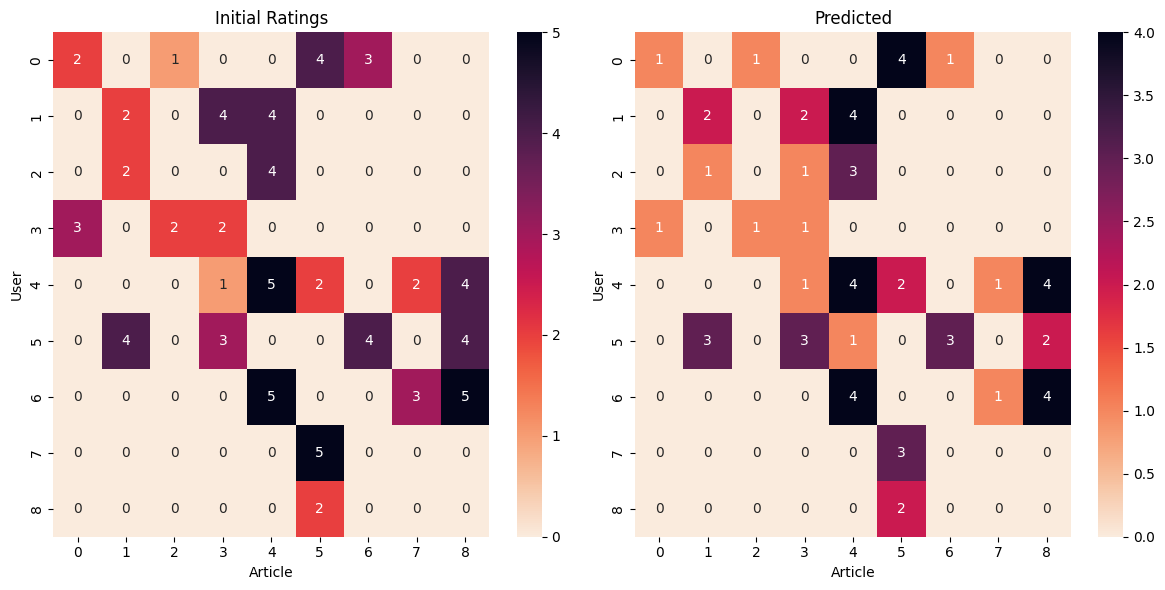

In [11]:
predicted_ratings = np.mean(ratings_samples, axis=0)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(np.round(inter_matrix), cmap=sns.cm.rocket_r, annot=True)
plt.xlabel("Article")
plt.ylabel("User")
plt.title('Initial Ratings')

plt.subplot(1, 2, 2)
sns.heatmap(np.round(predicted_ratings), cmap=sns.cm.rocket_r, annot=True)
plt.title('Predicted')
plt.xlabel("Article")
plt.ylabel("User")
plt.tight_layout()
plt.show()

Here's the heatmap of predicted values that were not rounded:

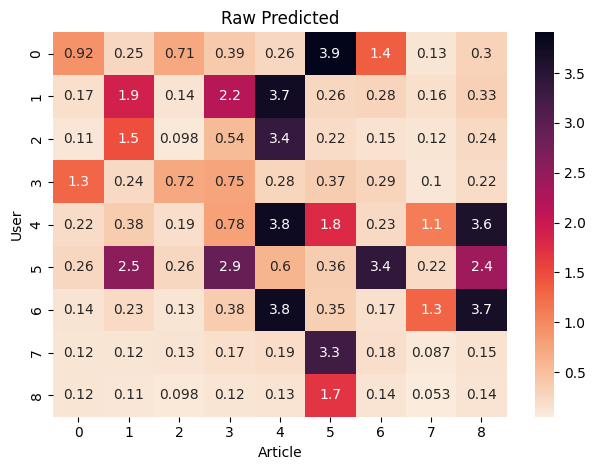

In [14]:
sns.heatmap(predicted_ratings, cmap=sns.cm.rocket_r, annot=True)
plt.title('Raw Predicted')
plt.xlabel("Article")
plt.ylabel("User")
plt.tight_layout()
plt.show()

On the left we have the histograms of the distributions used by the model, and on the right there are the actual traces. As expected, we observe no divergences (the divergece points would be displayed as black vertical lines), and the distributions converge rapidly. On the right side, the graphs indicate (through the peaks) where parameter values are more likely to occurr. 

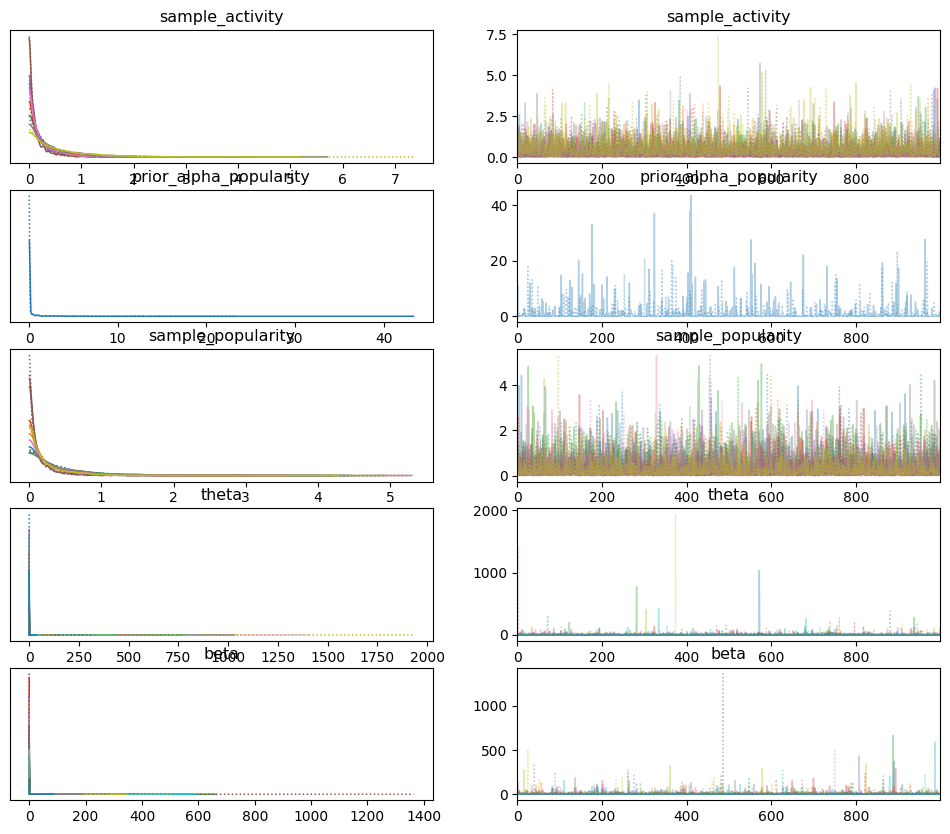

In [72]:
with pm.Model():
    az.plot_trace(trace)